# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing the file porter_data_1.csv
df = pd.read_csv(r'/content/drive/MyDrive/ML Assignment/porter_data_1.csv')

display(df.head())


market_id        created_at actual_delivery_time  store_primary_category  \
0          1  06-02-2015 22:24     06-02-2015 23:11                       4   
1          2  10-02-2015 21:49     10-02-2015 22:33                      46   
2          2  16-02-2015 00:11     16-02-2015 01:06                      36   
3          1  12-02-2015 03:36     12-02-2015 04:35                      38   
4          1  27-01-2015 02:12     27-01-2015 02:58                      38   

   order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0               1            4      3441                   4             557   
1               2            1      1900                   1            1400   
2               3            4      4771                   3             820   
3               1            1      1525                   1            1525   
4               1            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                     33                  14   
1            1400                      1                   2   
2            1604                      8                   6   
3            1525                      5                   6   
4            2195                      5                   5   

   total_outstanding_orders  distance  
0                        21     34.44  
1                         2     27.60  
2                        18     11.56  
3                         8     31.80  
4                         7      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [5]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df["created_at"] = pd.to_datetime(df["created_at"],format="%d-%m-%Y %H:%M")
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"],format="%d-%m-%Y %H:%M")


print(df.dtypes)


market_id                            int64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category               int64
order_protocol                       int64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers                int64
total_busy_dashers                   int64
total_outstanding_orders             int64
distance                           float64
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [6]:
# Convert categorical features to category type

df['market_id'] = df['market_id'].astype('category')
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [7]:
# Calculate time taken in minutes

df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [8]:
# Extract the hour and day of week from the 'created_at' timestamp

# Extracting the hour at which the order was placed
df['order_hour'] = df['created_at'].dt.hour

# Extracting the day of the week
df['order_day_of_week'] = df['created_at'].dt.dayofweek


# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Define isWeekend as category column
df['isWeekend'] = df['isWeekend'].astype('category')


In [9]:
# Drop unnecessary columns

# Droping the 'created_at' and 'actual_delivery_time' columns as they are no longer necessary
df = df.drop(['created_at', 'actual_delivery_time'], axis=1)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [10]:
# Define target variable (y) and features (X)

# Defining the target variable (y) as this is what we want to train model to eventually estimate
y = df['time_taken']

# Define the features (X)
X = df.drop('time_taken', axis=1)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [11]:
# Split data into training and testing sets

# Performing a 80-20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [12]:
display(X_train)

market_id store_primary_category order_protocol  total_items  subtotal  \
102712         2                     45              2            1       820   
94576          4                     20              3            1       995   
49784          1                     36              3            4      2040   
37753          3                     39              1            2      2376   
91728          2                      6              1            1      1430   
...          ...                    ...            ...          ...       ...   
119879         2                     58              5            1      1111   
103694         2                     24              1            4      2880   
131932         6                     46              5            2      1799   
146867         5                     36              2           10      4015   
121958         1                     55              3            4      4951   

        num_distinct_items  min_item_price  max_item_price  \
102712                   1             745             745   
94576                    1             995             995   
49784                    4             150             895   
37753                    2             579            1399   
91728                    1            1320            1320   
...                    ...             ...             ...   
119879                   1            1111            1111   
103694                   3             495             795   
131932                   2             300             899   
146867                   4             195             850   
121958                   4             549            1399   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
102712                     35                  39                        56   
94576                     110                  72                       116   
49784                       6                   3                         7   
37753                      16                  17                        19   
91728                      64                  47                        52   
...                       ...                 ...                       ...   
119879                     31                  31                        34   
103694                     95                  80                       111   
131932                     18                  18                        15   
146867                     26                  24                        28   
121958                     47                  27                        27   

        distance  order_hour  order_day_of_week isWeekend  
102712     30.32          21                  1         0  
94576      31.16           2                  4         0  
49784      18.16          21                  4         0  
37753      33.44           3                  1         0  
91728      31.56          21                  4         0  
...          ...         ...                ...       ...  
119879     37.04          23                  6         1  
103694     27.72           3                  2         0  
131932     21.92           1                  1         0  
146867     23.60           3                  5         1  
121958     18.04           3                  0         0  

[140621 rows x 15 columns]

In [13]:
X_train.describe()

total_items       subtotal  num_distinct_items  min_item_price  \
count  140621.000000  140621.000000       140621.000000   140621.000000   
mean        3.208582    2698.872530            2.676464      684.377589   
std         2.727133    1830.808391            1.626023      518.633806   
min         1.000000       0.000000            1.000000      -86.000000   
25%         2.000000    1418.000000            2.000000      299.000000   
50%         3.000000    2225.000000            2.000000      595.000000   
75%         4.000000    3415.000000            3.000000      940.000000   
max       411.000000   26800.000000           20.000000     8999.000000   

       max_item_price  total_onshift_dashers  total_busy_dashers  \
count   140621.000000          140621.000000       140621.000000   
mean      1159.948656              44.927948           41.880025   
std        559.693980              34.572455           32.197755   
min          0.000000              -4.000000           -5.000000   
25%        799.000000              17.000000           15.000000   
50%       1095.000000              37.000000           35.000000   
75%       1395.000000              66.000000           63.000000   
max       8999.000000             171.000000          154.000000   

       total_outstanding_orders       distance     order_hour  \
count             140621.000000  140621.000000  140621.000000   
mean                  58.245148      21.841054       8.475932   
std                   52.773640       8.751147       8.677293   
min                   -6.000000       0.000000       0.000000   
25%                   17.000000      15.320000       2.000000   
50%                   41.000000      21.760000       3.000000   
75%                   85.000000      28.120000      19.000000   
max                  285.000000      83.520000      23.000000   

       order_day_of_week  
count      140621.000000  
mean            3.221468  
std             2.044919  
min             0.000000  
25%             1.000000  
50%             3.000000  
75%             5.000000  
max             6.000000

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [14]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour']

categorical_cols = ['market_id', 'store_primary_category', 'order_protocol', 'order_day_of_week', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

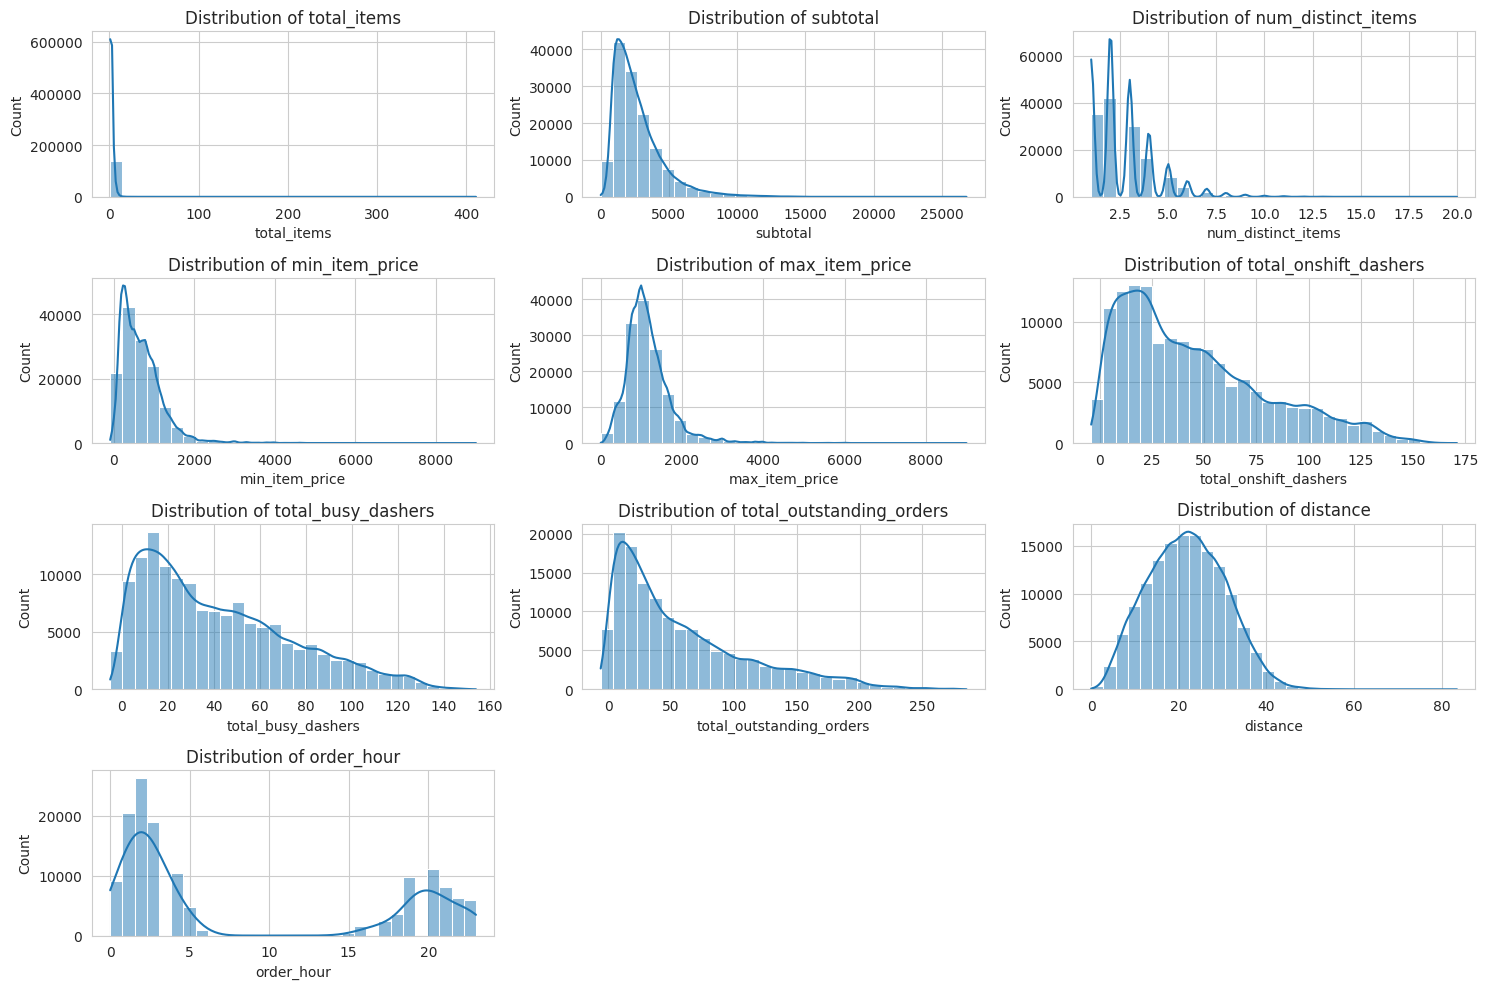

In [15]:
# Plot distributions for all numerical columns

sns.set_style("whitegrid")

# Ploting distributions for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
    sns.histplot(X_train[col], kde=True, bins=30)  # Ploting histogram with KDE
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

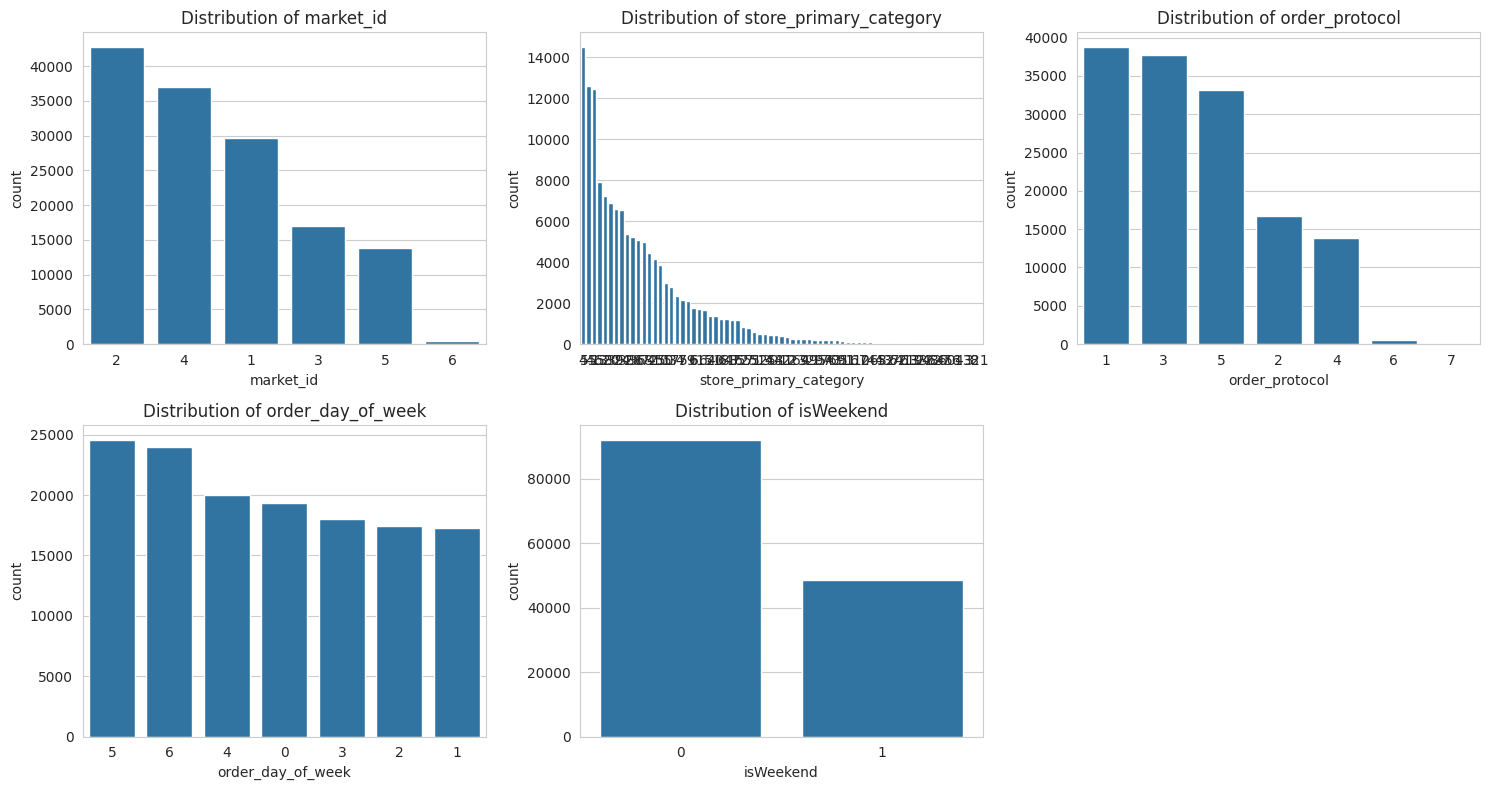

In [16]:
# Distribution of categorical columns

plt.figure(figsize=(15, 8))

# Plotting count plots for all categorical variables
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols) // 3 + 1, 3, i)
    sns.countplot(x=X_train[col], order=X_train[col].value_counts().index)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

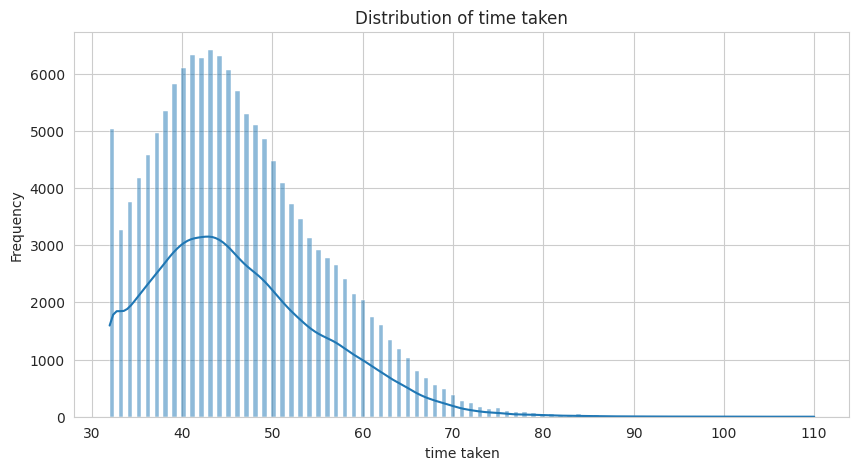

In [17]:
# Distribution of time_taken

plt.figure(figsize=(10, 5))
sns.histplot(y_train, kde=True)
plt.title('Distribution of time taken')
plt.xlabel('time taken')
plt.ylabel('Frequency')
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

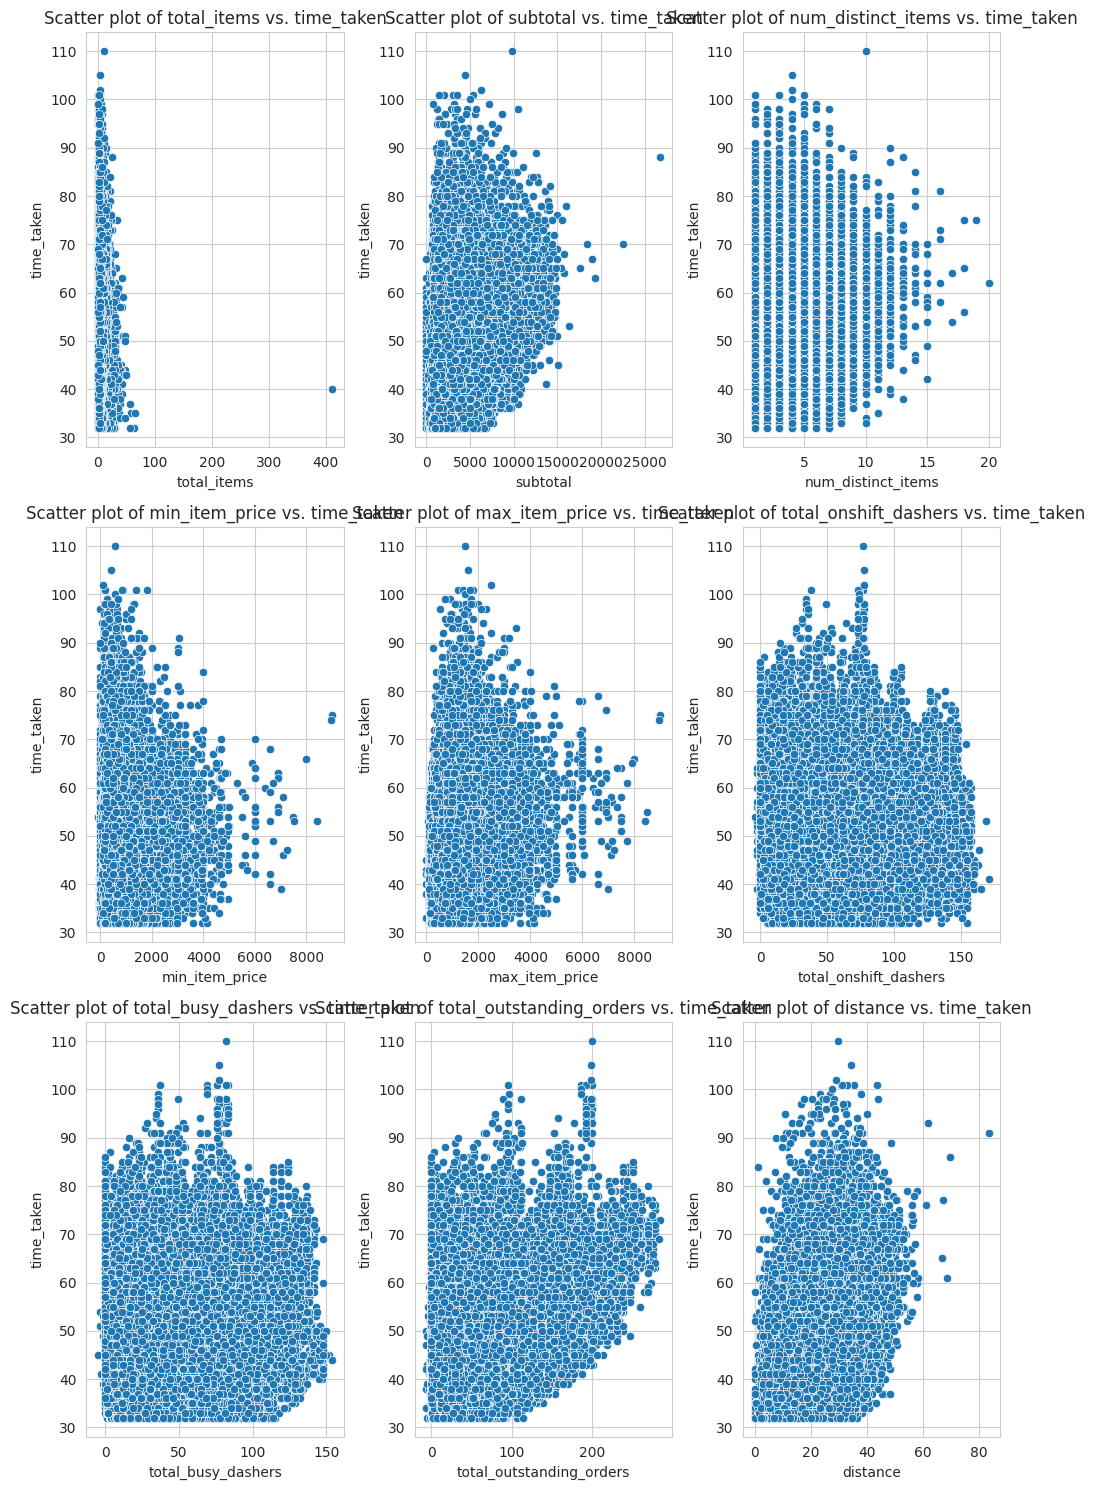

In [18]:
# Scatter plot to visualise the relationship between time_taken and other features

# scatter plots for each numerical column vs. time_taken
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

cols_per_row = 3  # Number of plots per row
num_cols = len(numerical_cols)
rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)  # Dynamic row calculation

# Creating subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to handle iteration easily

# Looping through numerical columns and ploting scatter plots
for i, col in enumerate(numerical_cols):
    sns.scatterplot(x=X_train[col], y=y_train, ax=axes[i])
    axes[i].set_title(f'Scatter plot of {col} vs. time_taken')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('time_taken')

plt.tight_layout()  # Adjusting layout for better spacing
plt.show()


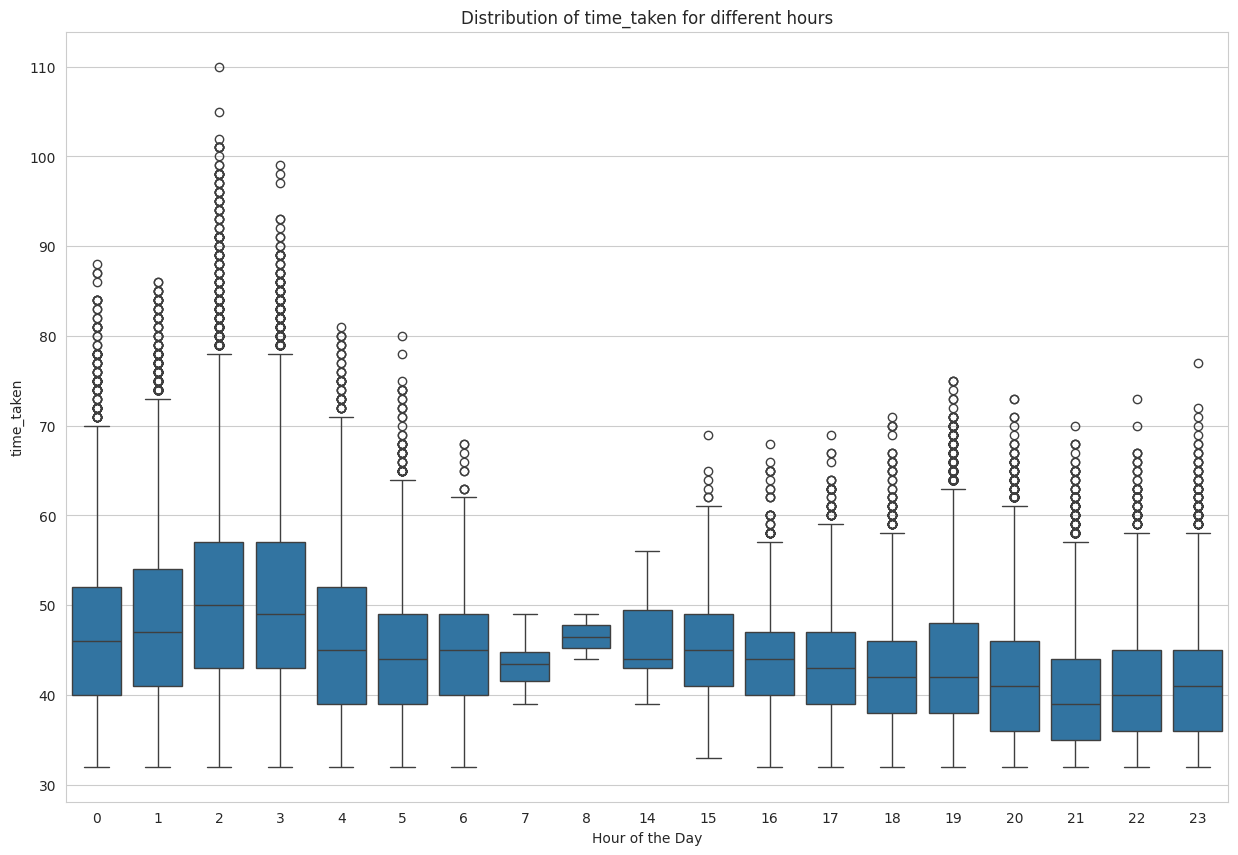

In [19]:
# Show the distribution of time_taken for different hours

# Creating a boxplot for time_taken for different hours
plt.figure(figsize=(15, 10))
sns.boxplot(x=X_train['order_hour'], y=y_train)
plt.title('Distribution of time_taken for different hours')
plt.xlabel('Hour of the Day')
plt.ylabel('time_taken')
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

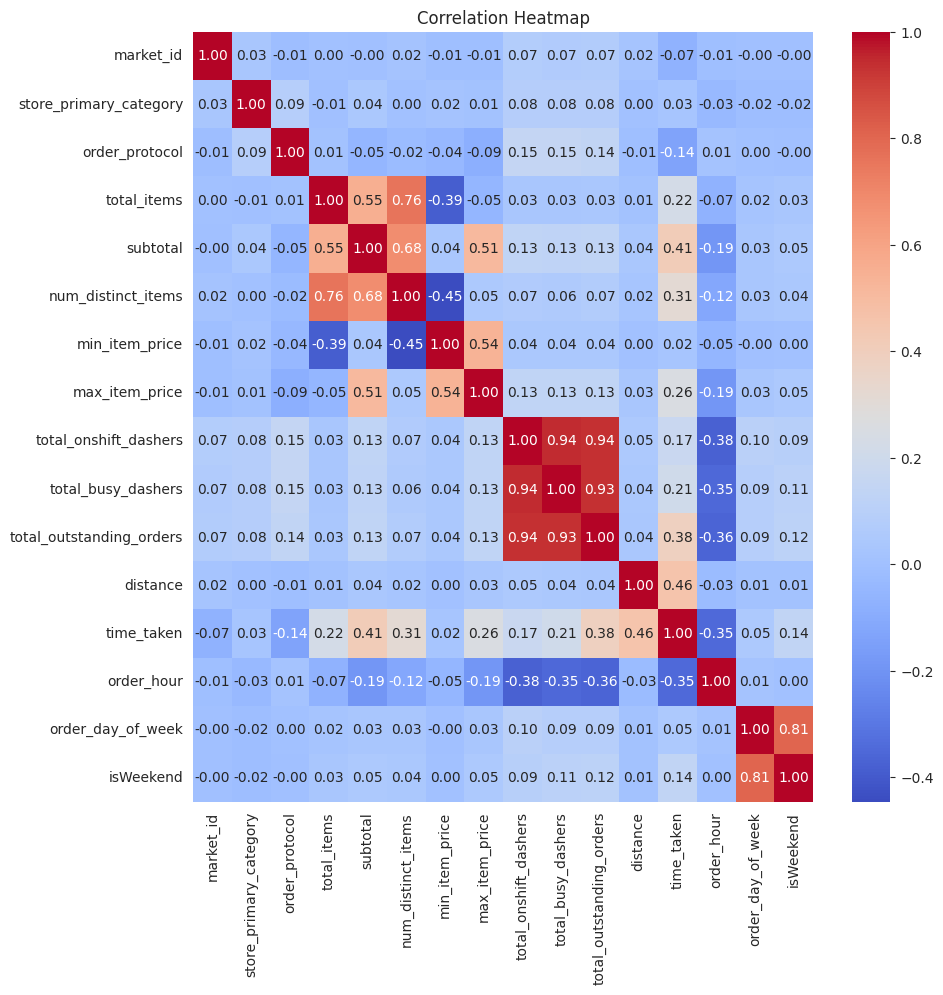

In [20]:
# Plot the heatmap of the correlation matrix

correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [21]:
# Drop 3-5 weakly correlated columns from training dataset

# Compute correlation with target variable 'time_taken'
correlation_matrix = df.corr()
time_taken_corr = correlation_matrix["time_taken"].abs()  # Use absolute values

# Define a threshold for weak correlation (e.g., 0.1)
threshold = 0.1

# Select columns with correlation above the threshold
strong_corr_features = time_taken_corr[time_taken_corr > threshold].index

# Drop weak correlation columns
df_filtered = df[strong_corr_features]

print(f"Retained Columns: {list(df_filtered.columns)}")

Retained Columns: ['order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'order_hour', 'isWeekend']


In [22]:
X_train_modify = X_train[strong_corr_features.drop("time_taken", errors="ignore")]

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

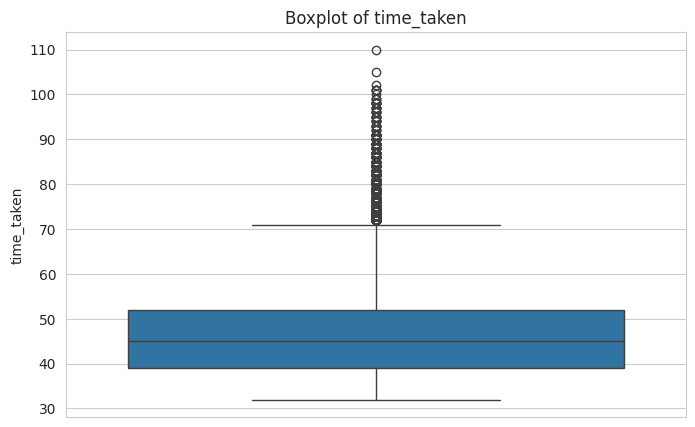

In [23]:
# Boxplot for time_taken

plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train)
plt.title("Boxplot of time_taken")
plt.ylabel("time_taken")
plt.show()


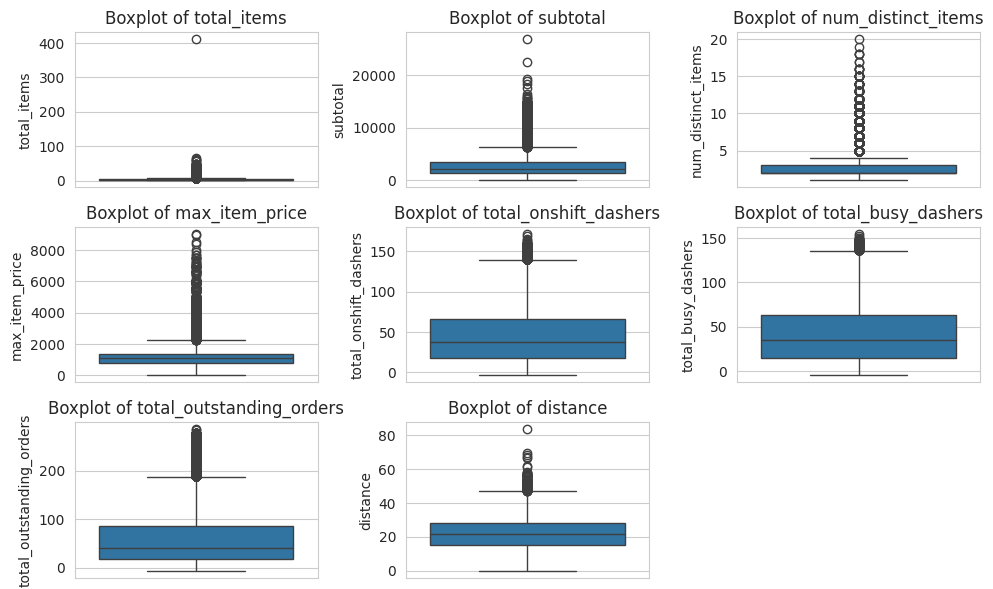

In [24]:
numerical_cols = X_train_modify.select_dtypes(include=['int64', 'float64']).columns

# Define subplot grid
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i)  # 3 columns per row
    sns.boxplot(y=X_train_modify[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [25]:
# Handle outliers

# Using Capping (Winsorization) method to handle outliers since dataset is large and do not want a data loss
def cap_outliers(X_train_modify, numerical_cols):
    X_train_modify = X_train_modify.copy()
    for col in numerical_cols:
        lower_percentile = X_train_modify[col].quantile(0.05)  # 5th percentile
        upper_percentile = X_train_modify[col].quantile(0.95)  # 95th percentile

        X_train_modify.loc[:, col] = np.clip(X_train_modify[col], lower_percentile, upper_percentile)

    return X_train_modify

X_train_capped = cap_outliers(X_train_modify, numerical_cols)

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [26]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [27]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [28]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [29]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [30]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [31]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [32]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [33]:
# Apply scaling to the numerical columns

numerical_cols = X_train_capped.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()  # Use Standardization

# Fit and transform on training data
X_train_scaled = scaler.fit_transform(X_train_capped[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])  # Using transform() only for test set

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [34]:
# Create/Initialise the model
model = LinearRegression()

In [35]:
# Train the model using the training data

model.fit(X_train_scaled, y_train)



LinearRegression()

In [36]:
# Make predictions

y_pred = model.predict(X_test_scaled)

In [37]:
# Find results for evaluation metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, MSE: {mse}, R² Score: {r2}")


MAE: 3.2370884807185956, MSE: 17.757376898974865, R² Score: 0.7971218108010296


In [38]:
X_train_capped.columns

Index(['order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend'],
      dtype='object')

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [39]:
# Loop through the number of features and test the model

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_cols)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=numerical_cols)

# Initialize model and RFE
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=8)

# Fitting RFE to training data
rfe.fit(X_train_scaled, y_train)

selected_features = X_train_scaled.columns[rfe.support_]

# Selecting only the important features
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print("Selected Features:", list(selected_features))

Selected Features: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


In [40]:
# Build the final model with selected number of features

model.fit(X_train_selected, y_train)

# Making predictions on training and test sets
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

# Evaluating model performance
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display Model Performance comparison for train data and test data
print("Model Performance:")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

Model Performance:
Train MAE: 3.2471, Test MAE: 3.2371
Train MSE: 18.2139, Test MSE: 17.7574
Train R²: 0.7903, Test R²: 0.7971


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

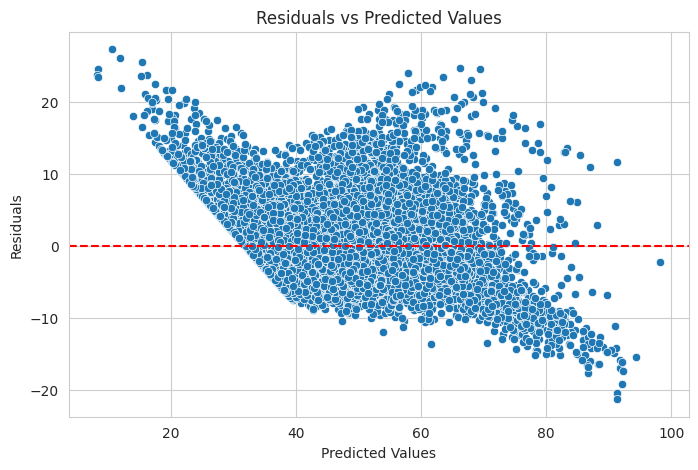

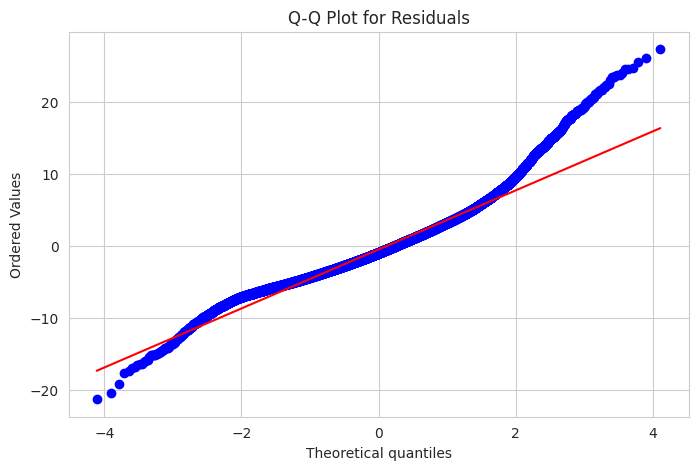

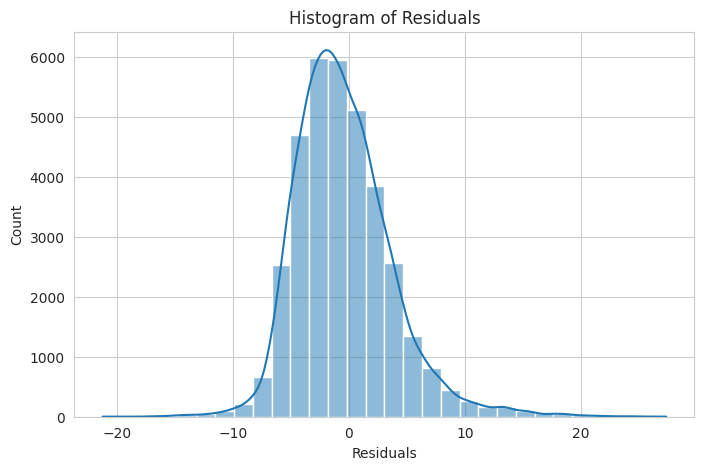

In [41]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

residuals = y_test - y_test_pred

# Residuals vs Predicted Values Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot for Residuals")
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [42]:
# Compare the scaled vs unscaled features used in the final model

# calculating scaled Features
# Extracting coefficients from the trained model
coefficients = model.coef_

coef_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Display the coefficients
print("Scaled Coefficients (Standardized Features):")
print(coef_df)

Scaled Coefficients (Standardized Features):
                    Feature  Coefficient
6  total_outstanding_orders    19.456726
7                  distance     4.122486
1                  subtotal     2.467043
2        num_distinct_items     0.945011
3            max_item_price     0.661040
0               total_items    -0.096216
5        total_busy_dashers    -4.589756
4     total_onshift_dashers   -13.168158


In [43]:
#Calculating unscaled Features

original_std = X_train_capped[selected_features].std()
unscaled_coefficients = coefficients * original_std  # Converting coefficients to unscaled values

unscaled_coef_df = pd.DataFrame({'Feature': selected_features, 'Unscaled Coefficient': unscaled_coefficients})
unscaled_coef_df = unscaled_coef_df.sort_values(by='Unscaled Coefficient', ascending=False)

# Display the unscaled coefficients
print("\nUnscaled Coefficients (Original Feature Scale):")
print(unscaled_coef_df)


Unscaled Coefficients (Original Feature Scale):
                                           Feature  Unscaled Coefficient
subtotal                                  subtotal           3717.147483
total_outstanding_orders  total_outstanding_orders            952.792057
max_item_price                      max_item_price            287.630752
distance                                  distance             33.810364
num_distinct_items              num_distinct_items              1.349450
total_items                            total_items             -0.168921
total_busy_dashers              total_busy_dashers           -140.203725
total_onshift_dashers        total_onshift_dashers           -432.224981


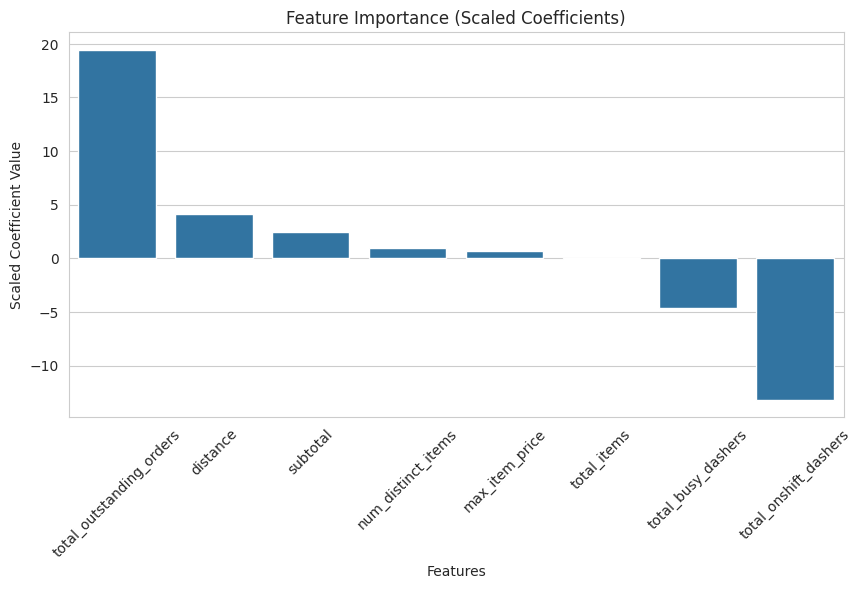

In [44]:
#Visulaizing feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=coef_df['Feature'], y=coef_df['Coefficient'])
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Scaled Coefficient Value")
plt.title("Feature Importance (Scaled Coefficients)")
plt.show()

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [45]:
# Analyze the effect of a unit change in a feature, say 'total_items'

feature_name = "total_items"

scaled_coefficient = coef_df[coef_df['Feature'] == feature_name]['Coefficient'].values[0]

original_std = X_train_capped[feature_name].std()

# Convert to unscaled coefficient
unscaled_coefficient = scaled_coefficient * original_std

print(f"Effect of a unit change in '{feature_name}':")
print(f"Scaled Coefficient: {scaled_coefficient:.4f}")
print(f"Unscaled Coefficient: {unscaled_coefficient:.4f}")


Effect of a unit change in 'total_items':
Scaled Coefficient: -0.0962
Unscaled Coefficient: -0.1689


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> The categorical variables identified in the dataset were market_id, store_primary_category, and order_protocol as these are likely codes representing different categories. However, they are represented as integers in the dataset. The effect of this categorial variables could be :-
1. **market_id**: Different markets may have different delivery times due to factors such as distance, traffic conditions, and the efficiency of the delivery personnel in that market.
2.**store_primary_category**: The type of store could affect delivery times. For example, some types of stores might prepare their products faster than others. Additionally, certain types of food might be quicker to prepare and deliver.
3. **order_protocol**: The protocol used to place the order could also affect delivery times. Some protocols might be more efficient, leading to faster preparation and delivery times.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> It referes that the overall datset is splitted into 80%-20% where 80% data is used for training the model while remaining 20% will be used for testing the model.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> From the heatmap, the variable that has the highest correlation with the target variable time_taken is distance with a correlation value of approximately 0.46.
This suggests that as the distance increases, the delivery time (time_taken) also tends to increase,



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> To detect outliers I plotted box plots for all the numical features.
I noticed that there was large number of outliers. Remmoving then will result in loss of data therefore used method called Capping (Winsorization) using which I limited extreme values at the 5th and 95th percentile:



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Based on the unscaled coefficients, the top 3 features significantly affecting delivery time are:

1. subtotal (Coefficient: 3717.15)

This has the highest positive impact, meaning an increase in subtotal significantly increases delivery time.

2. total_outstanding_orders (Coefficient: 952.79)

The number of outstanding orders also has a major impact, possibly indicating delays due to high order volume.

3. max_item_price (Coefficient: 287.63)

Higher-priced items might be associated with complex or time-consuming deliveries.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a fundamental algorithm in supervised learning, seeks to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data. The core objective is to find the best-fitting line that minimizes the difference between predicted and actual values.

The equation of a simple linear regression model is : y = β₀ + β₁x + ε
Here, β₀ represents the intercept (the value of y when x is zero), β₁ represents the slope (the change in y for a unit change in x), and ε represents the error term.

3 Types of Linear Regression are :
1. Simple Linear Regression: Involves only one independent variable.

2. Multiple Linear Regression: Involves two or more independent variables.

3. Polynomial Regression: A form of linear regression where polynomial features are added to capture non-linear relationships.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> The amjor difference between simple linear regression and multiple linear regression lies in the number of independent variables used to predict the dependent variable.

1. Simple linear regression is a statistical model that examines the linear relationship between one independent variable (predictor) and one dependent variable (response).

2. Multiple linear regression is a statistical model that examines the linear relationship between two or more independent variables (predictors) and one dependent variable (response)



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> In Linear Regression, the cost function measures how well the model's predicted values match the actual values in the dataset. The goal of training a regression model is to minimize this cost function to achieve the best possible predictions.

For linear regression, a common cost function is the Mean Squared Error (MSE). It calculates the average of the squared differences between the predicted values (y^) and the actual values (y) for all data points

To find the best-fit line, we minimize a cost function using either the Normal Equation or Gradient Descent. The Normal Equation directly calculates optimal coefficients but is computationally expensive for large datasets. Gradient Descent iteratively updates parameters based on the cost function's gradient and a learning rate, making it suitable for large datasets.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> The difference between overfitting and underfitting in ML models, including linear regression, comes down to how well the model generalizes to new, unseen data after being trained on a specific dataset.

1. **Overfitting** occurs when a model learns the training data too well, capturing noise and random fluctuations rather than the true relationship between the features and the target variable. As a result, the model performs exceptionally well on the training data but poorly on new, unseen data.

Some Characteristics of Overfitting:
  1. Very low error on training data but high error on test data.

  2. The model is too complex, with too many parameters or features.

  3. Captures noise in the dataset instead of just the underlying pattern.

2. **Underfitting** occurs when a model is too simple and fails to capture the underlying pattern in the training data. It results in high error on both training and test data.

Some Characteristics of Underfitting are:
1. High error on both training and test data.

2. The model is too simple (e.g., a linear model on non-linear data).

3. It does not learn enough from the training data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots are a powerful tool for diagnosing the adequacy of a linear regression model. They help us assess whether the assumptions of linear regression are being met and identify potential problems with the model.

They are typically scatter plots where the residuals are plotted on the vertical axis and either predicted values or independdent vlaues are plotted on the horizontal axis:

By examining the scatter of points in a residual plot, we can look for:

1. Random scatter around zero: Suggests linearity and homoscedasticity.
2. Non-linear patterns (such as curves, etc.): Suggests a non-linear relationship is present.
3. Funnel shapes or non-constant spread: Suggests heteroscedasticity.
4. Patterns or trends in the order of residuals: Suggests non-independence of errors.
5. Strong asymmetry or unusual distribution: May suggest non-normality of errors.